In [5]:
import pathlib
import skimage
import cv2
import numpy as np
import pandas as pd
from skimage import feature
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
import math
%matplotlib inline  

In [6]:
im_dir = pathlib.Path('F:/device/optics/32w_Realtime_test_5th/2')

In [7]:
temp_li = ['Low Temp', 'High Temp']
x_range = slice(400, 1900)
y_range = slice(400, 1900)
colors_li = [plt.cm.get_cmap('hsv', 30)(i) for i in range(30)]

In [8]:
ch_dict = {
    0: 'CalRed',
    1: 'FAM',
    2: 'Q670',
    3: 'HEX'
}

In [9]:
im_dict = {}
for ch in range(4):
    ch_name = ch_dict[ch]
    im_dict[ch_name] = {}
    for t in range(2):
        im_dict[ch_name][temp_li[t]] = {}
        for c in range(45):
            im_dict[ch_name][temp_li[t]][c] = {}
            fpath = im_dir/f'{c}_{t}_{ch}.jpg'
            im = np.array(Image.open(fpath))
            im_cropped = im[x_range, y_range]

            im_gray = cv2.cvtColor(im_cropped, cv2.COLOR_BGR2GRAY)

            thresh = skimage.filters.threshold_mean(im_gray)
            threshed_im = im_gray > thresh
            im_dict[ch_name][temp_li[t]][c]['thresh'] = threshed_im

            bw = skimage.morphology.closing(threshed_im, skimage.morphology.disk(3))
            bw2 = skimage.morphology.opening(bw, skimage.morphology.disk(3))
            cleared = skimage.segmentation.clear_border(bw2)
            im_labeled = skimage.measure.label(cleared)
            im_dict[ch_name][temp_li[t]][c]['labeled'] = im_labeled
            
            region_raw_dict = {}
            for region in skimage.measure.regionprops(im_labeled, intensity_image=im_gray):
                region_raw_dict[region.area] = region
            im_dict[ch_name][temp_li[t]][c]['regions'] = region_raw_dict
        

In [10]:
result_dict = {}
for temp in temp_li:
    result_dict[temp] = {}
    for ch in ch_dict.values():
        result_dict[temp][ch] = {}

In [11]:
im_dict[ch][temp][44]['regions']

{3190: <skimage.measure._regionprops._RegionProperties at 0x1da82c28240>,
 11826: <skimage.measure._regionprops._RegionProperties at 0x1da82c287b8>,
 10888: <skimage.measure._regionprops._RegionProperties at 0x1da82c28470>,
 12249: <skimage.measure._regionprops._RegionProperties at 0x1da82c28710>,
 3546: <skimage.measure._regionprops._RegionProperties at 0x1da82c28160>,
 6656: <skimage.measure._regionprops._RegionProperties at 0x1da82c28668>,
 15349: <skimage.measure._regionprops._RegionProperties at 0x1da82c28780>,
 15960: <skimage.measure._regionprops._RegionProperties at 0x1da82c28b38>,
 9190: <skimage.measure._regionprops._RegionProperties at 0x1da82c28ac8>,
 11515: <skimage.measure._regionprops._RegionProperties at 0x1da82c28978>,
 13995: <skimage.measure._regionprops._RegionProperties at 0x1da82c282b0>,
 9330: <skimage.measure._regionprops._RegionProperties at 0x1da82c280b8>,
 14503: <skimage.measure._regionprops._RegionProperties at 0x1da82c28390>,
 11246: <skimage.measure._regi

In [12]:
row = list('ABCD')[::-1]
result_dict = {'well_grid': {}}
for temp in temp_li:
    result_dict['well_grid'][temp] = {}

for ch in ch_dict.values():
    for temp in temp_li:
        regions = im_dict[ch][temp][44]['regions']
        minr_li = []
        minc_li = []
        maxr_li = []
        maxc_li = []
        for region in regions.values():
            minr, minc, maxr, maxc = region.bbox
            minr_li.append(minr)
            minc_li.append(minc)
            maxr_li.append(maxr)
            maxc_li.append(maxc)
        minr_li.sort()
        top = minr_li[0]
        minc_li.sort()
        left = minc_li[0]
        maxr_li.sort()
        bottom = maxr_li[-1]
        maxc_li.sort()
        right = maxc_li[-1]

        well_box = [top-50, left-50, bottom+50, right+50]
        y_li = np.linspace(well_box[0], well_box[2], 5, endpoint=True)
        x_li = np.linspace(well_box[1], well_box[3], 5, endpoint=True)
        pts_x = []
        pts_y = []
        for x in x_li:
            for y in y_li:
                pts_x.append(x)
                pts_y.append(y)
        pts_li = list(zip(pts_x, pts_y))
        
        i = 0
        well_location_dict = {}
        for x in range(4):
            for y in range(4):
                key = row[y]+str(x+1)
                top_left_pt = pts_li[i+y+x]
                bottom_right_pt = pts_li[i+y+x+6]
                well_location_dict[key] = [top_left_pt[1], top_left_pt[0], bottom_right_pt[1], bottom_right_pt[0]]
            i += 4
        result_dict['well_grid'][temp][ch] = well_location_dict
        
            

In [13]:
result_dict['well_grid']['Low Temp']['CalRed']

{'D1': [31.0, 366.0, 296.25, 600.5],
 'C1': [296.25, 366.0, 561.5, 600.5],
 'B1': [561.5, 366.0, 826.75, 600.5],
 'A1': [826.75, 366.0, 1092.0, 600.5],
 'D2': [31.0, 600.5, 296.25, 835.0],
 'C2': [296.25, 600.5, 561.5, 835.0],
 'B2': [561.5, 600.5, 826.75, 835.0],
 'A2': [826.75, 600.5, 1092.0, 835.0],
 'D3': [31.0, 835.0, 296.25, 1069.5],
 'C3': [296.25, 835.0, 561.5, 1069.5],
 'B3': [561.5, 835.0, 826.75, 1069.5],
 'A3': [826.75, 835.0, 1092.0, 1069.5],
 'D4': [31.0, 1069.5, 296.25, 1304.0],
 'C4': [296.25, 1069.5, 561.5, 1304.0],
 'B4': [561.5, 1069.5, 826.75, 1304.0],
 'A4': [826.75, 1069.5, 1092.0, 1304.0]}

In [14]:
def get_well_loc(x, y, pts_center, well_location_dict):
    for well in well_location_dict.keys():
        y_min, x_min, y_max, x_max = well_location_dict[well]
        if y_min < y < y_max and x_min < x < x_max:
            radius = (x_max-x_min)/2 - 50
            pts_given = np.array([x, y])
            distance = np.linalg.norm(pts_given-pts_center)
            if distance < radius:
                return well

In [15]:
def get_grid_loc(x, y, well_location_dict):
    for well in well_location_dict.keys():
        y_min, x_min, y_max, x_max = well_location_dict[well]
        if y_min < y < y_max and x_min < x < x_max:
            return well

In [17]:
region_sum_dict = {}
    
for t in range(2):
    temp = temp_li[t]
    region_sum_dict[temp] = {}
    for ch in ch_dict.values():
        region_sum_dict[temp][ch] = {}
        for well in well_location_dict.keys():
            region_sum_dict[temp][ch][well] = [0]*45

        for c in range(45):
            sorted_region_key = list(im_dict[ch][temp][c]['regions'].keys())
            sorted_region_key.sort(reverse=True)

            center_at_cycle = {}
            for key in sorted_region_key:
                region_obj = im_dict[ch][temp][c]['regions'][key]
                y, x = region_obj.centroid
                grid = get_grid_loc(x, y, result_dict['well_grid'][temp][ch])
                if grid is None:
                    continue
            
                if grid not in center_at_cycle.keys():
                    center = [x, y]
                    center_at_cycle[grid] = center
                else:
                    center = center_at_cycle[grid]
                well = get_well_loc(x, y, center, result_dict['well_grid'][temp][ch])

                if well is not None:
                    val = region_sum_dict[temp_li[t]][ch][well][c]
                    val += region_obj.intensity_image.sum()
                    region_sum_dict[temp_li[t]][ch][well][c] = val

result_dict['rfu_sum'] = region_sum_dict


In [31]:
ch_dict.values()

dict_values(['CalRed', 'FAM', 'Q670', 'HEX'])

In [18]:
dict_before = pd.read_excel('F:/device/optics/32w_Realtime_test_5th/5차 2번카메라.xlsx', sheet_name=None, header=None)
dict_before.keys()

odict_keys(['fam60', 'hex60', 'cal60', 'qua60', 'fam72', 'hex72', 'cal72', 'qua72'])

In [26]:
df = dict_before['fam60']
df

D1      D2      D3      D4      C1      C2      C3      C4      B1  \
0   45841  122714  115249   47317  159241  354639  360273  159439  217330   
1   43353  116732  112159   46362  149806  338644  352249  158645  205554   
2   45011  122730  114589   46271  150569  342402  353387  160476  204505   
3   43897  124110  117059   45744  147735  339499  351869  161300  199116   
4   43311  123093  116435   44464  144758  335128  350619  160355  196681   
5   31191   98474   99840   37459  124177  307261  323422  151217  183874   
6   31628  105131  101799   37672  122126  303434  321620  152215  182142   
7   30875  103588  102367   37854  121517  303578  320172  153096  179439   
8   30402  104079  103481   37183  120726  300185  318065  151311  178150   
9   29934  103800  104377   35991  119772  299734  318194  152334  176492   
10  29293  102885  104478   34589  117247  298880  317068  151771  175497   
11  29647  102049  103796   33380  117223  296149  317512  151649  173169   
12  29922  102939  106518   34482  116100  295130  314883  151220  174100   
13  29666  100954  106761   33680  115127  292644  312467  149898  173124   
14  29096  101773  106813   33765  115023  292895  310190  147951  171816   
15  28806  100342  107214   33782  114039  291975  312184  149547  170679   
16  27884  100425  106361   33221  112331  287501  307732  148870  171159   
17  27588  100437  106970   33886  111896  287728  307865  147905  169649   
18  27765   99110  108314   33348  112520  286749  307214  149026  168287   
19  27647  100504  107134   34013  110913  286731  305908  147854  168411   
20  27044   98627  105557   33808  109961  283909  304754  146834  166088   
21  27406   94256  104612   34147  110547  283073  303956  146528  166944   
22  27284   93584  105242   33998  109430  281012  303709  146317  165594   
23  27928   92691  106548   34067  108535  281946  301988  146010  167387   
24  27420   94055  104756   34815  108640  280270  302645  143403  165775   
25  26724   91330  104926   34162  108272  278595  300995  143729  163441   
26  26793   93011  104515   33816  107918  277802  299252  143817  164154   
27  27155   92279  104131   34033  108233  279409  303195  143488  164183   
28  26296   93090  105036   33632  108323  279046  301134  143431  163945   
29  26441   93664  105619   34955  108295  280049  304676  144730  164209   
30  26597   94107  107341   35053  108669  280838  308246  146718  164415   
31  27154   95531  109732   35454  110515  285669  314304  151203  166526   
32  27695   98610  112691   36757  111748  289476  322809  154831  169670   
33  28846  100972  119491   38929  116747  300360  336877  162557  173696   
34  29847  105139  124283   40707  121137  309467  345679  167746  181549   
35  31804  115376  132316   43473  124683  322059  361691  178486  186866   
36  33901  122465  138858   46909  135056  336194  379886  187257  198125   
37  36707  132742  150134   51254  141770  354307  403731  198111  205635   
38  36388  143986  168619   65703  145983  386086  452858  229784  214699   
39  41066  158039  182936   72926  158607  412113  483222  247717  227118   
40  46620  174309  198071   80013  173168  441800  514001  265386  241679   
41  56928  200979  230864   97650  202536  496174  573760  303142  279821   
42  63025  215882  248103  107564  216563  521270  599146  322193  298733   
43  68074  225932  261414  114369  229829  542243  622186  337259  313804   

        B2      B3      B4      A1      A2      A3      A4  
0   411200  387879  173026  151721  316275  317554  185391  
1   399409  386515  176443  150016  319358  322322  188086  
2   402995  378857  174305  151727  320317  323005  184624  
3   399747  377233  175199  151718  323114  325385  186847  
4   396073  376349  173881  151105  321844  324471  188692  
5   381807  384910  175358  150932  332446  337118  195266  
6   381293  390261  174429  148718  331193  336435  193579  
7   380587  389988  174696  149942  335531  338766  1

In [27]:
len(df)

44

In [19]:
map_dict = {
    'CalRed': 'cal',
    'FAM': 'fam',
    'HEX': 'hex',
    'Q670': 'qua',
    'L': '60',
    'H': '72'
}
row = list('ABCD')[::-1]
col_li = []
for y in range(4):
    for x in range(4):
        key = row[y]+str(x+1)
        col_li.append(key)
col_li

['D1',
 'D2',
 'D3',
 'D4',
 'C1',
 'C2',
 'C3',
 'C4',
 'B1',
 'B2',
 'B3',
 'B4',
 'A1',
 'A2',
 'A3',
 'A4']

In [20]:
result_dict['rfu_sum']['Low Temp'].keys()

dict_keys(['CalRed', 'FAM', 'Q670', 'HEX'])

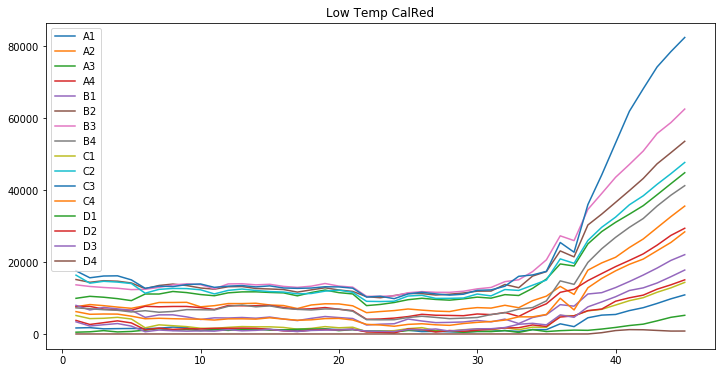

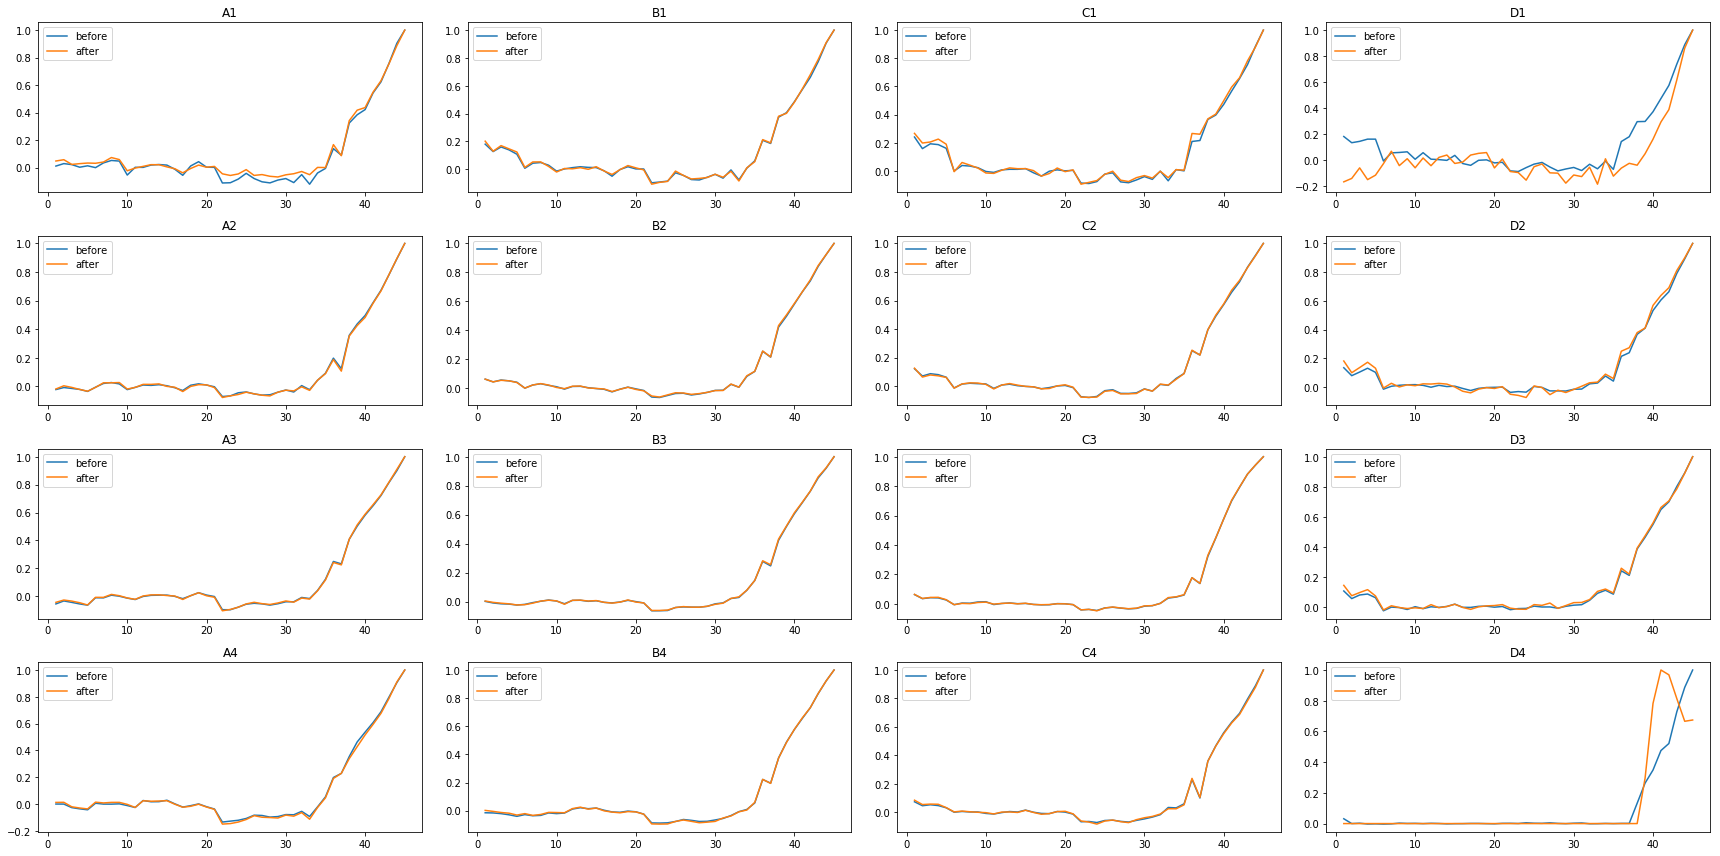

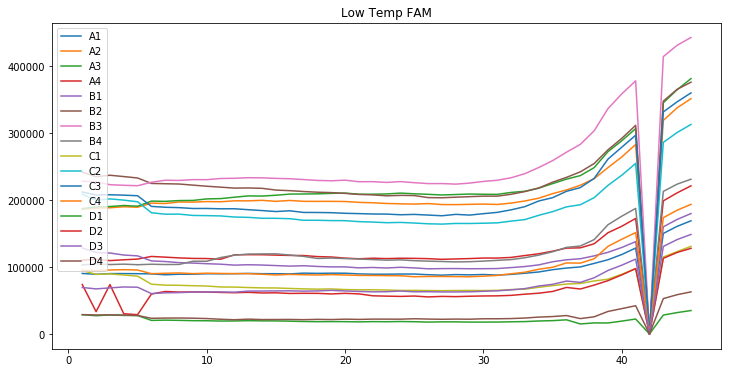

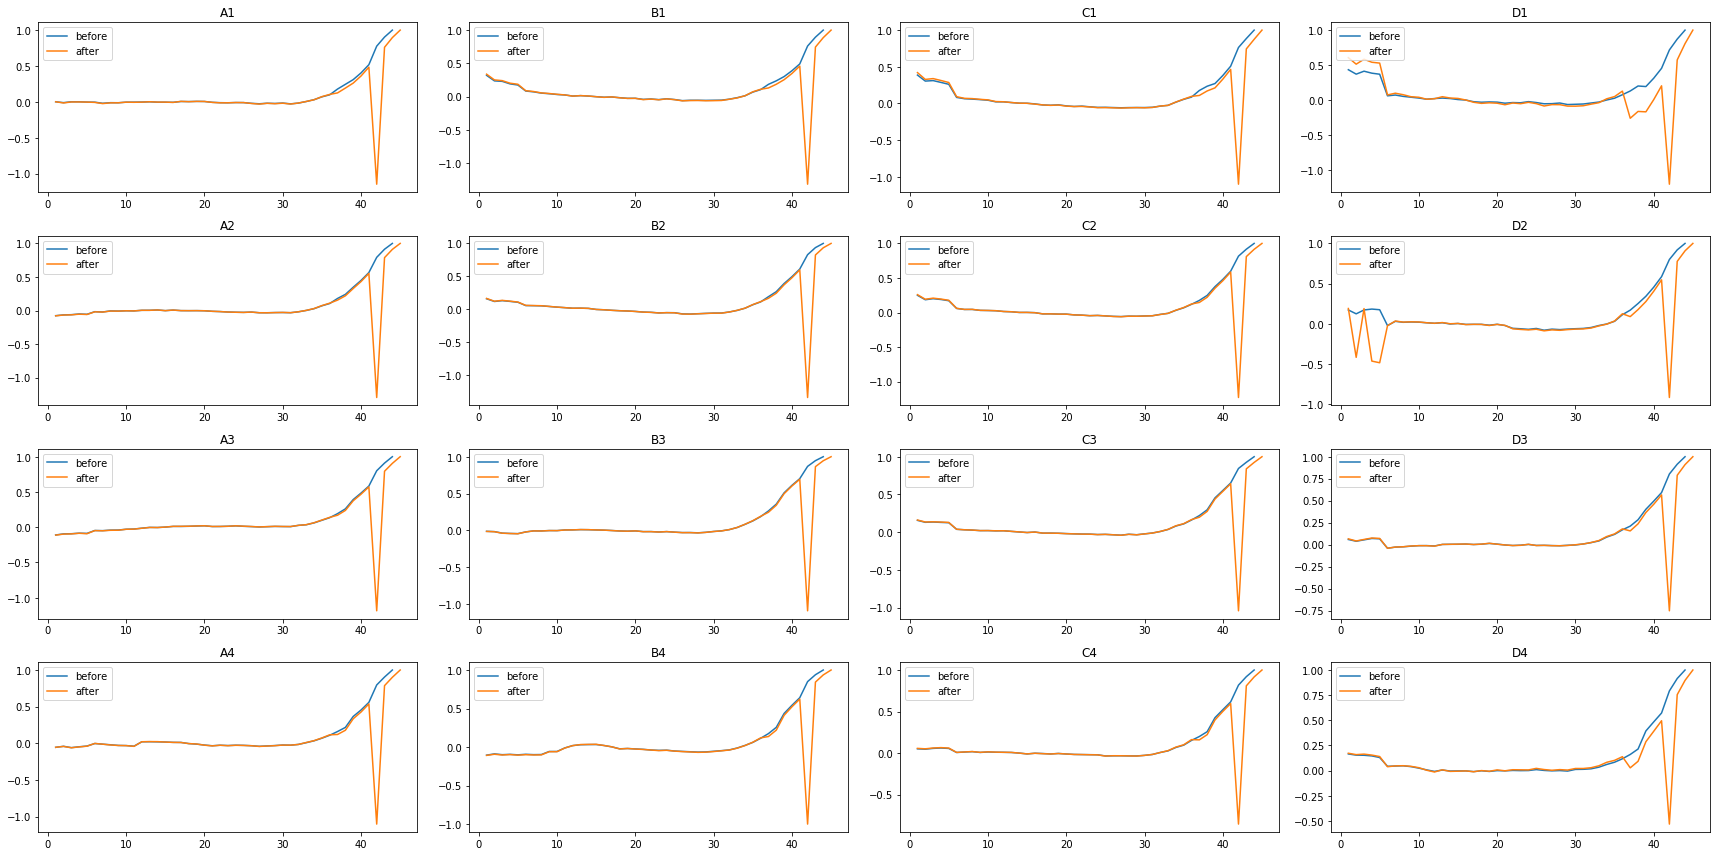

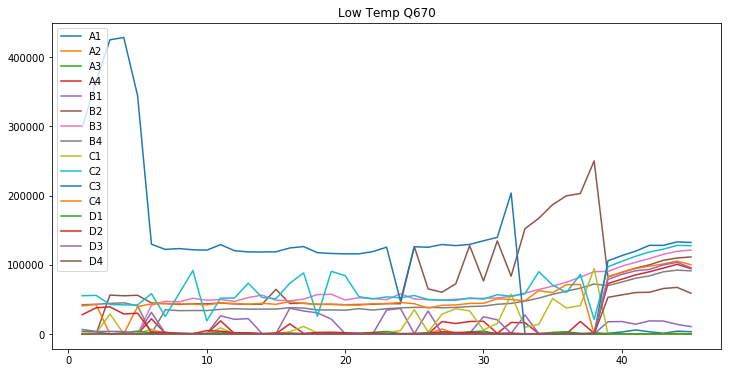

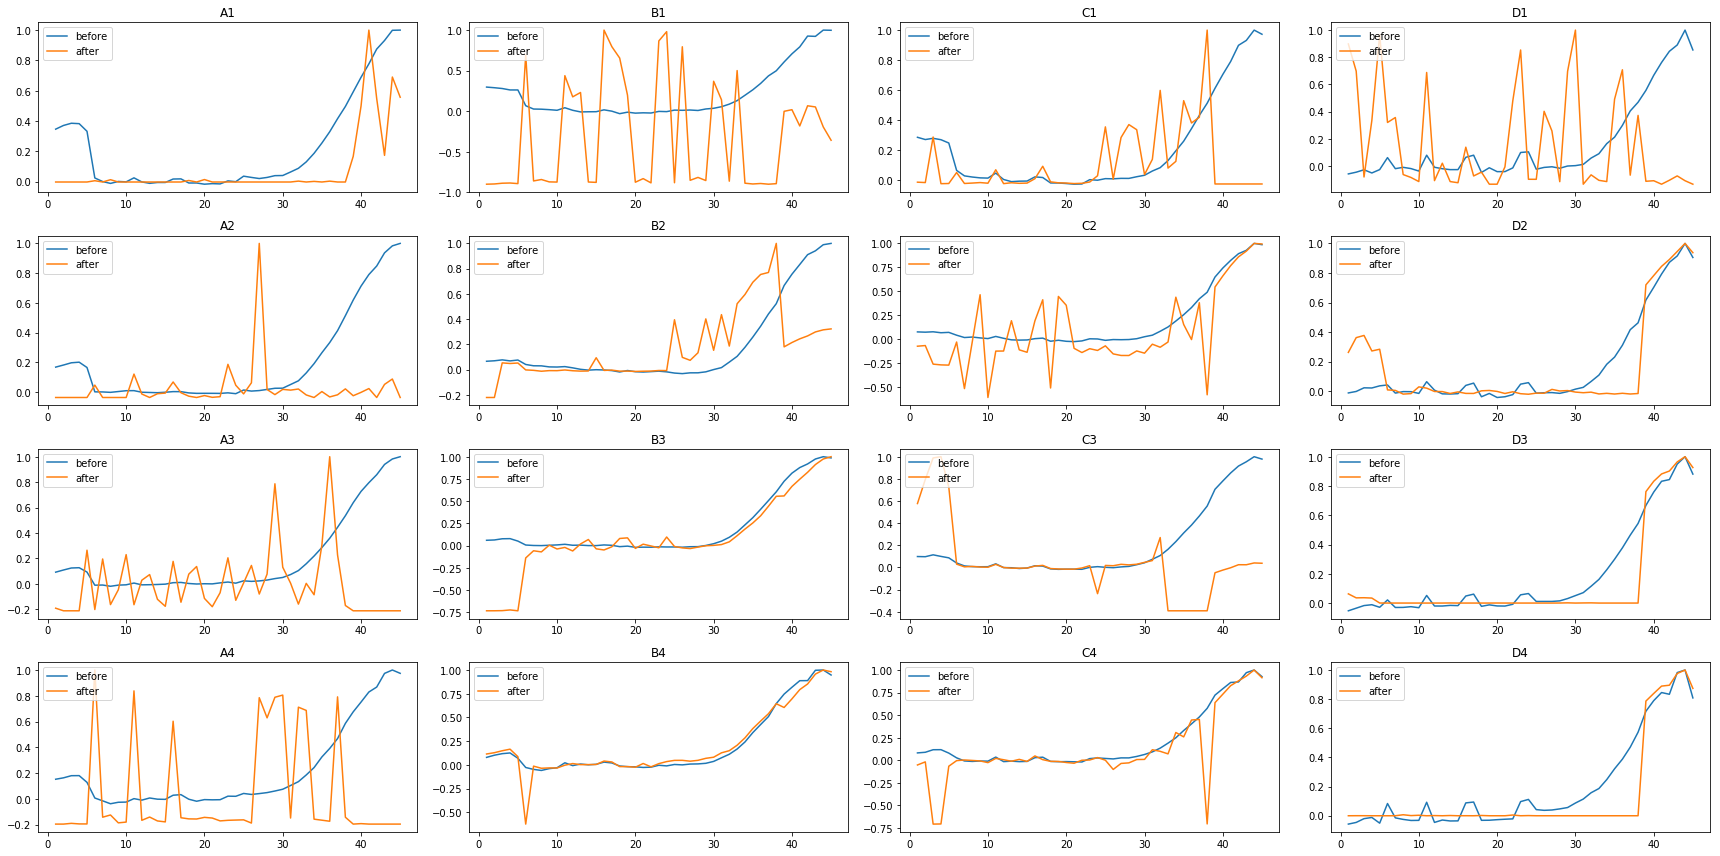

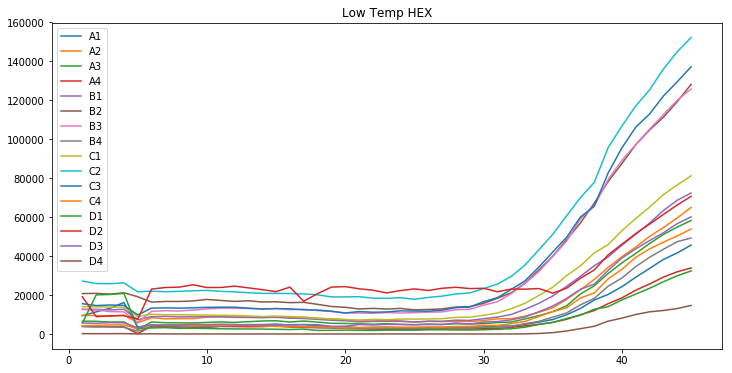

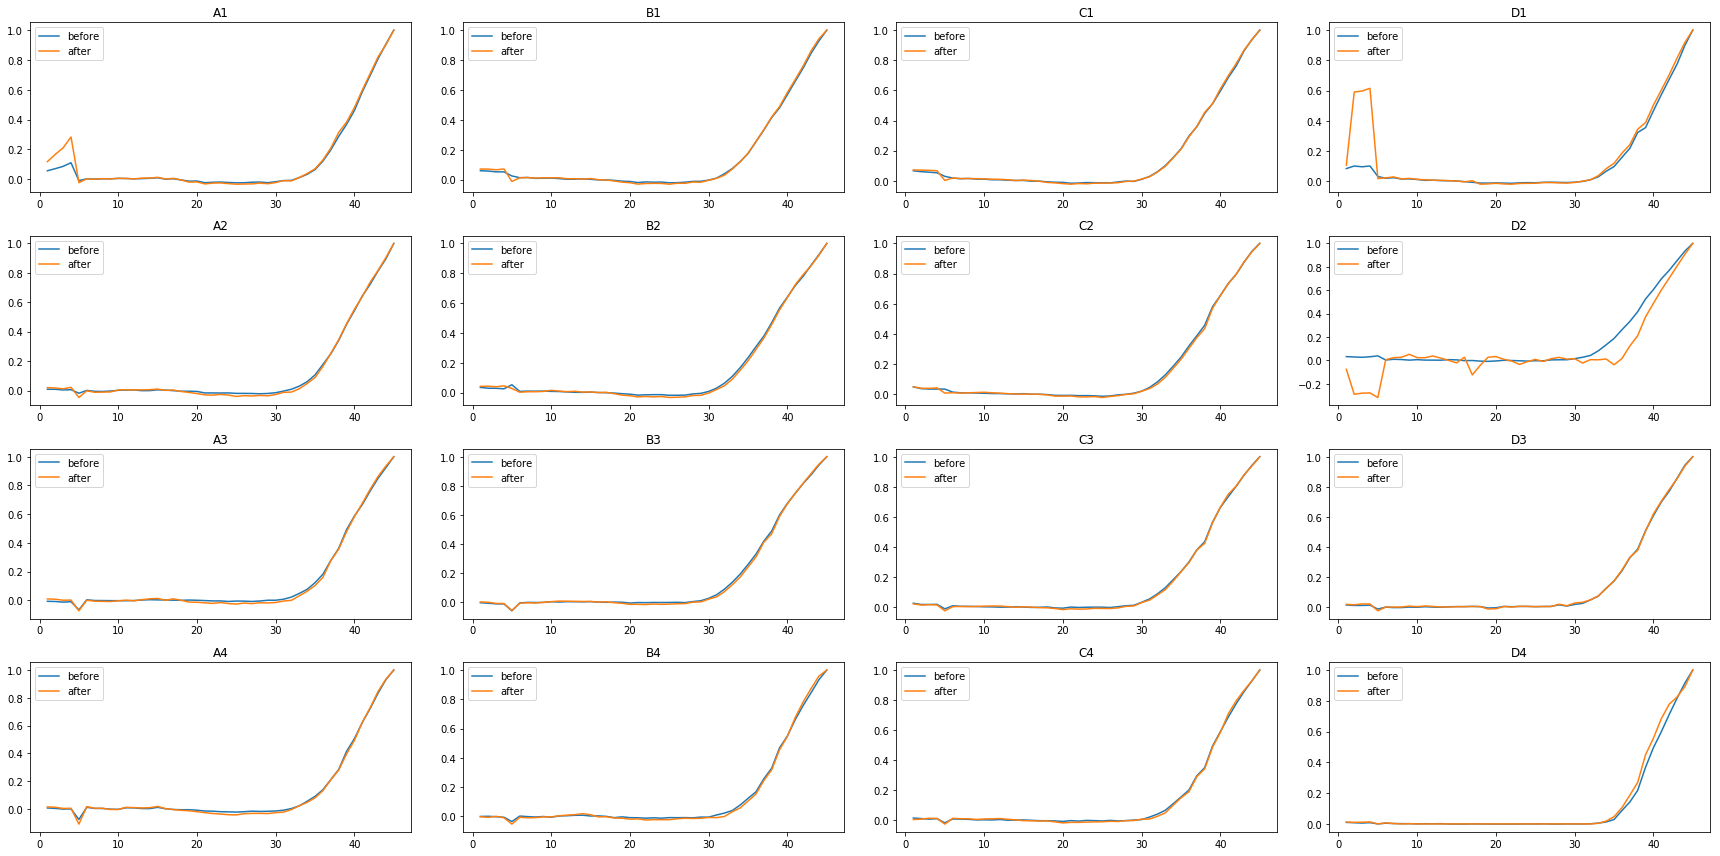

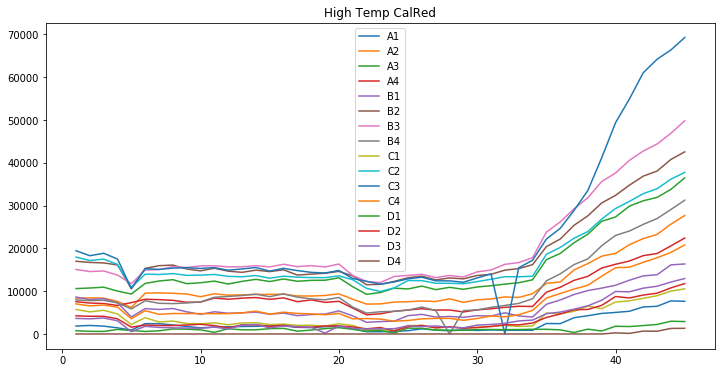

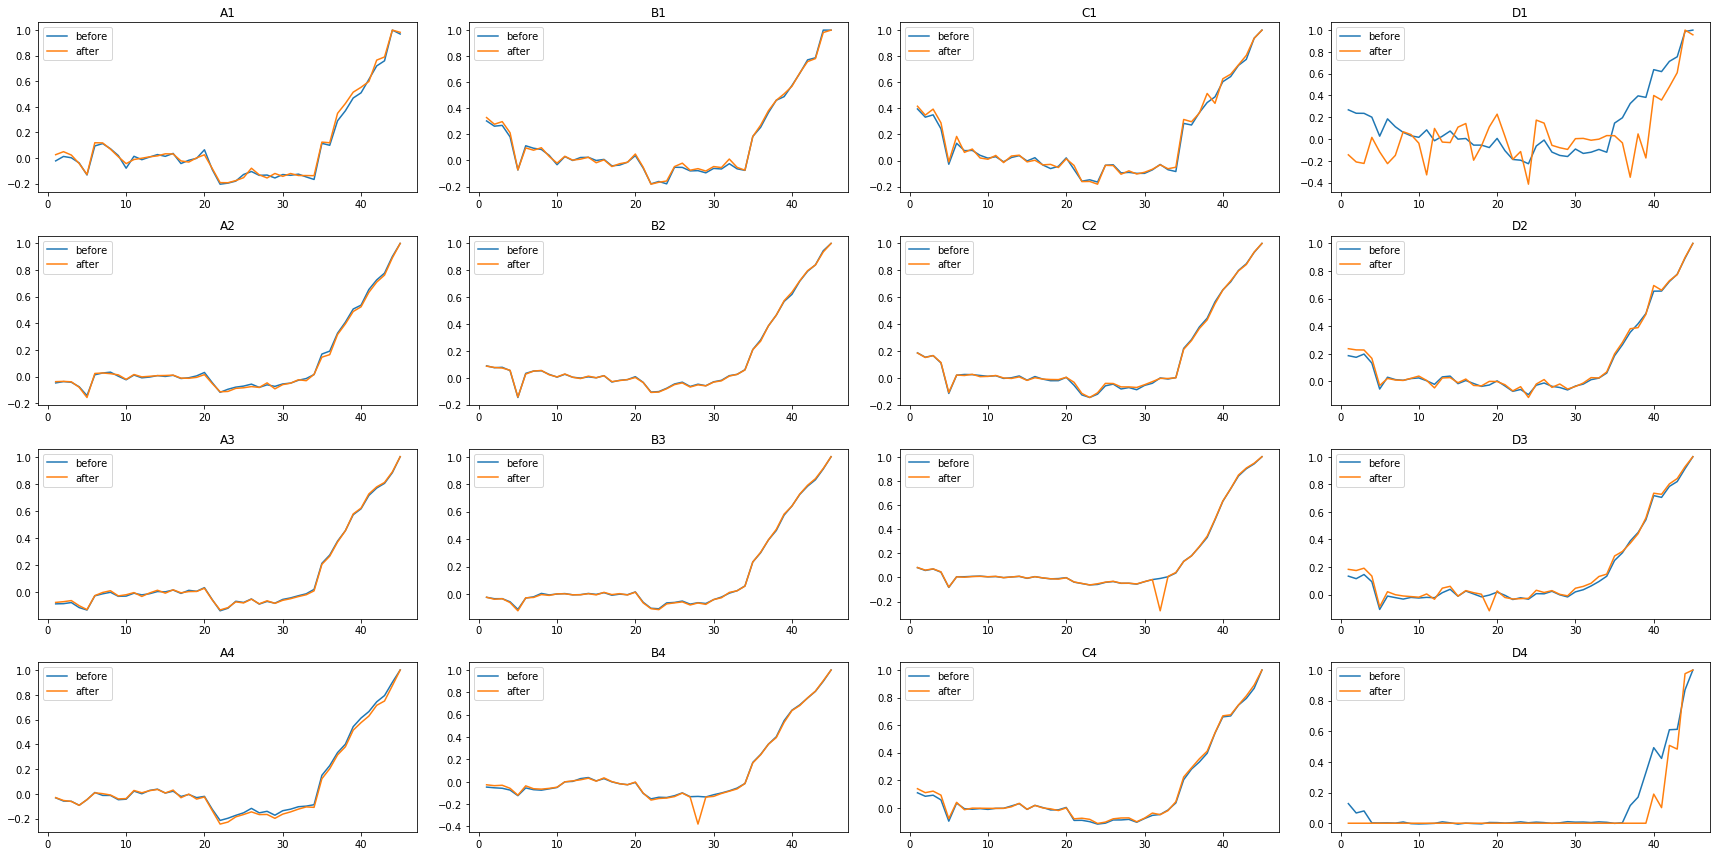

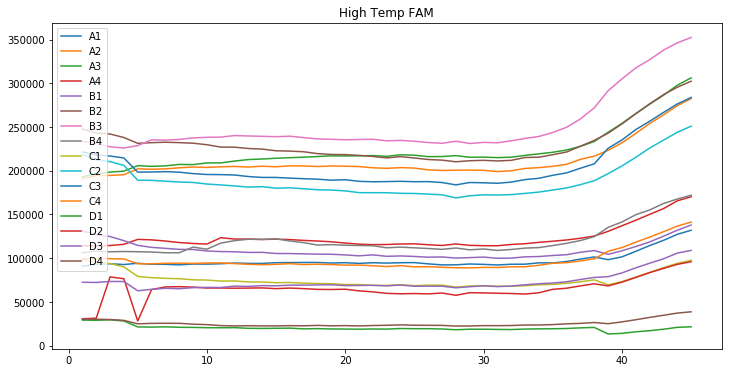

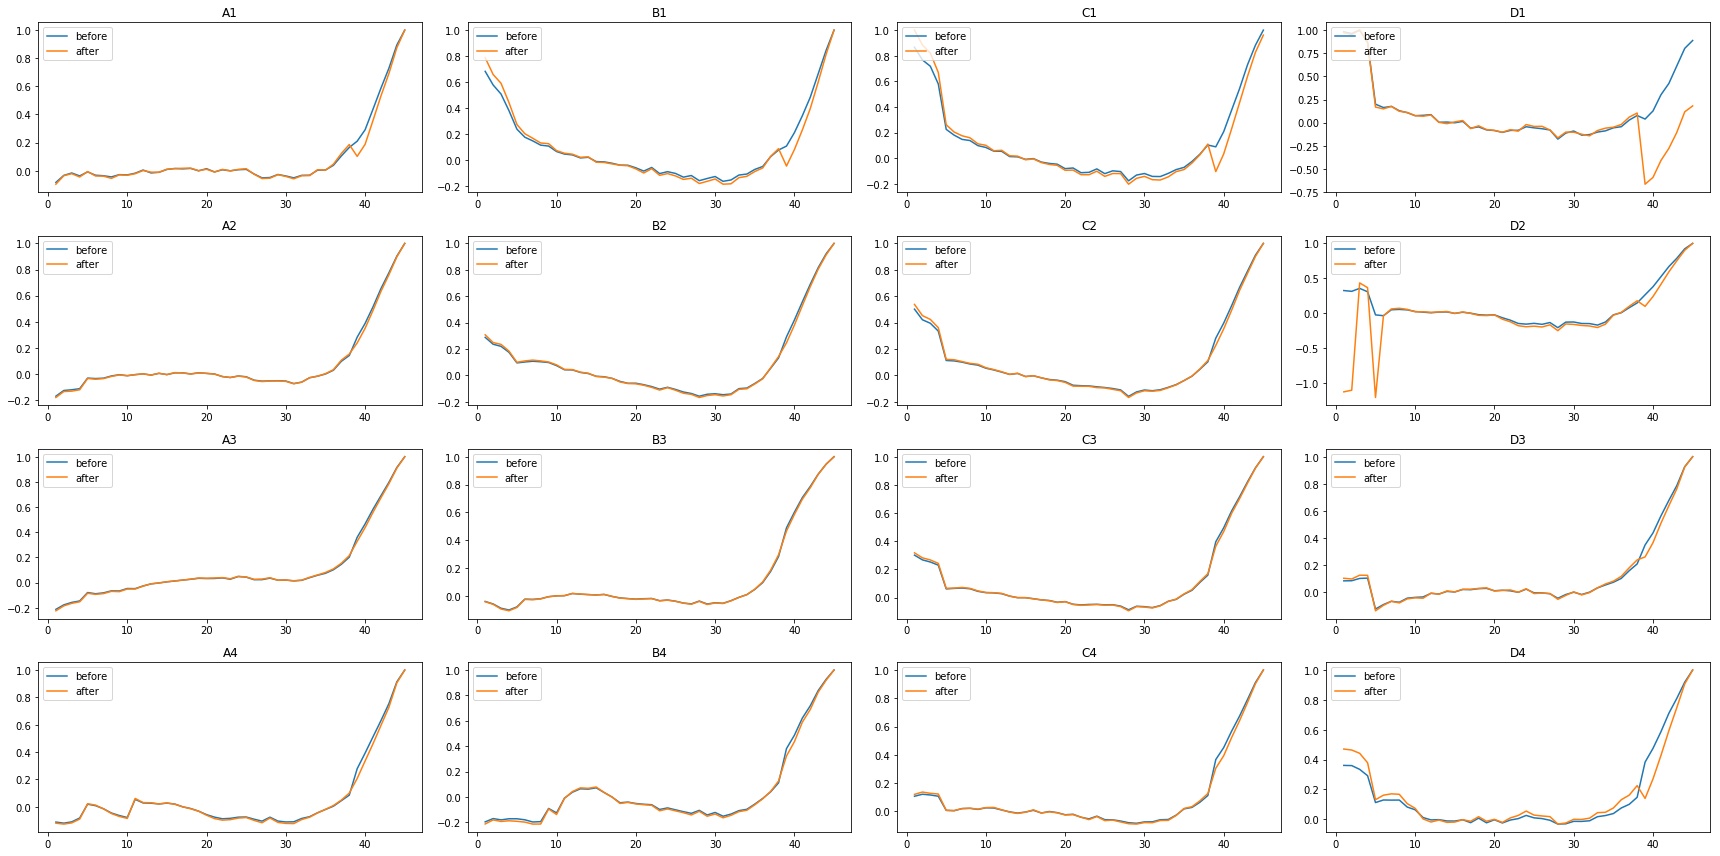

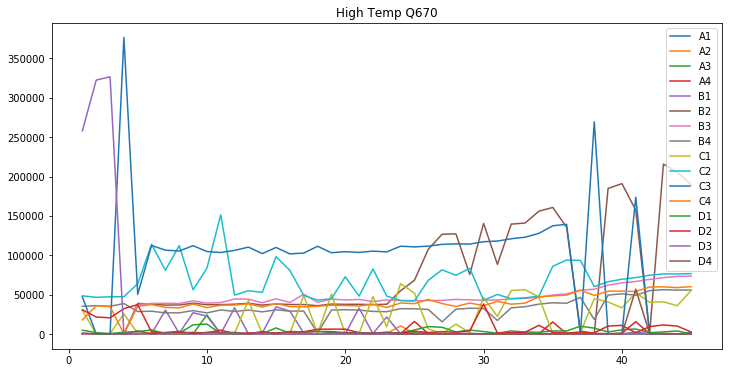

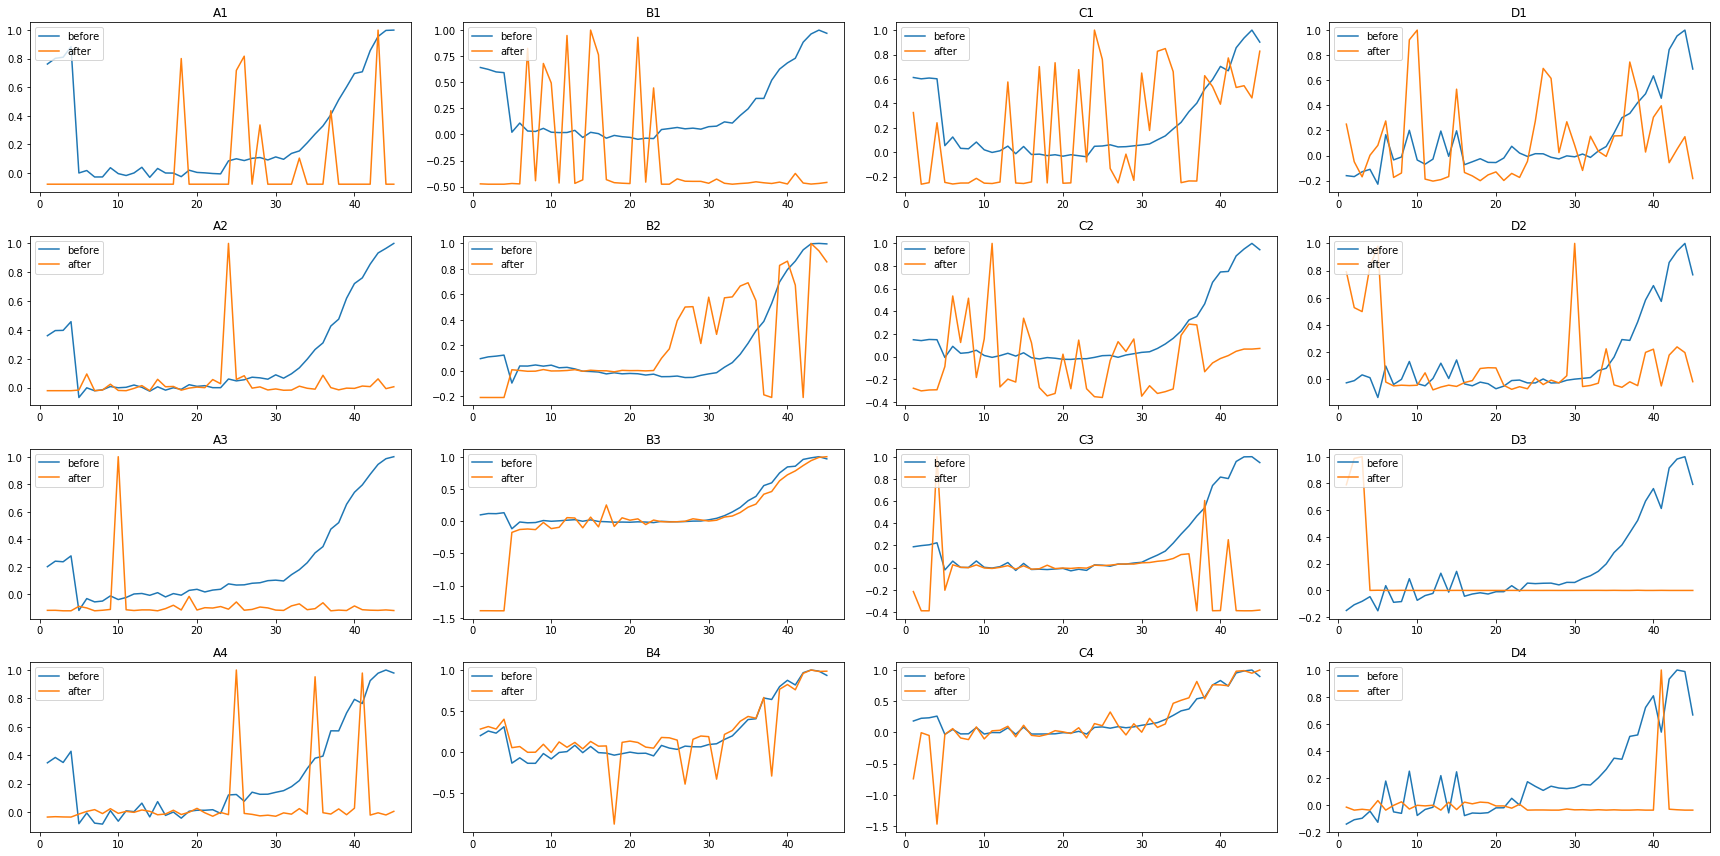

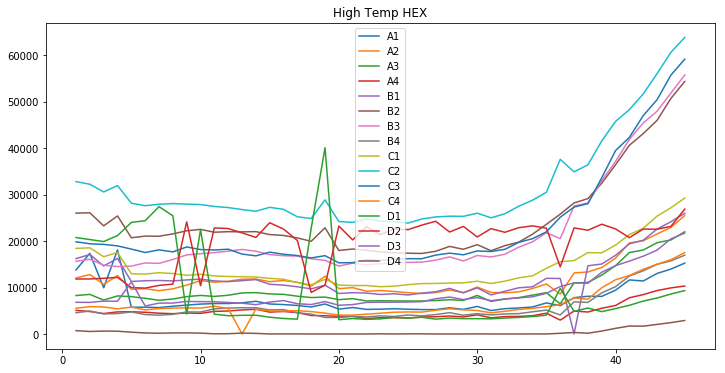

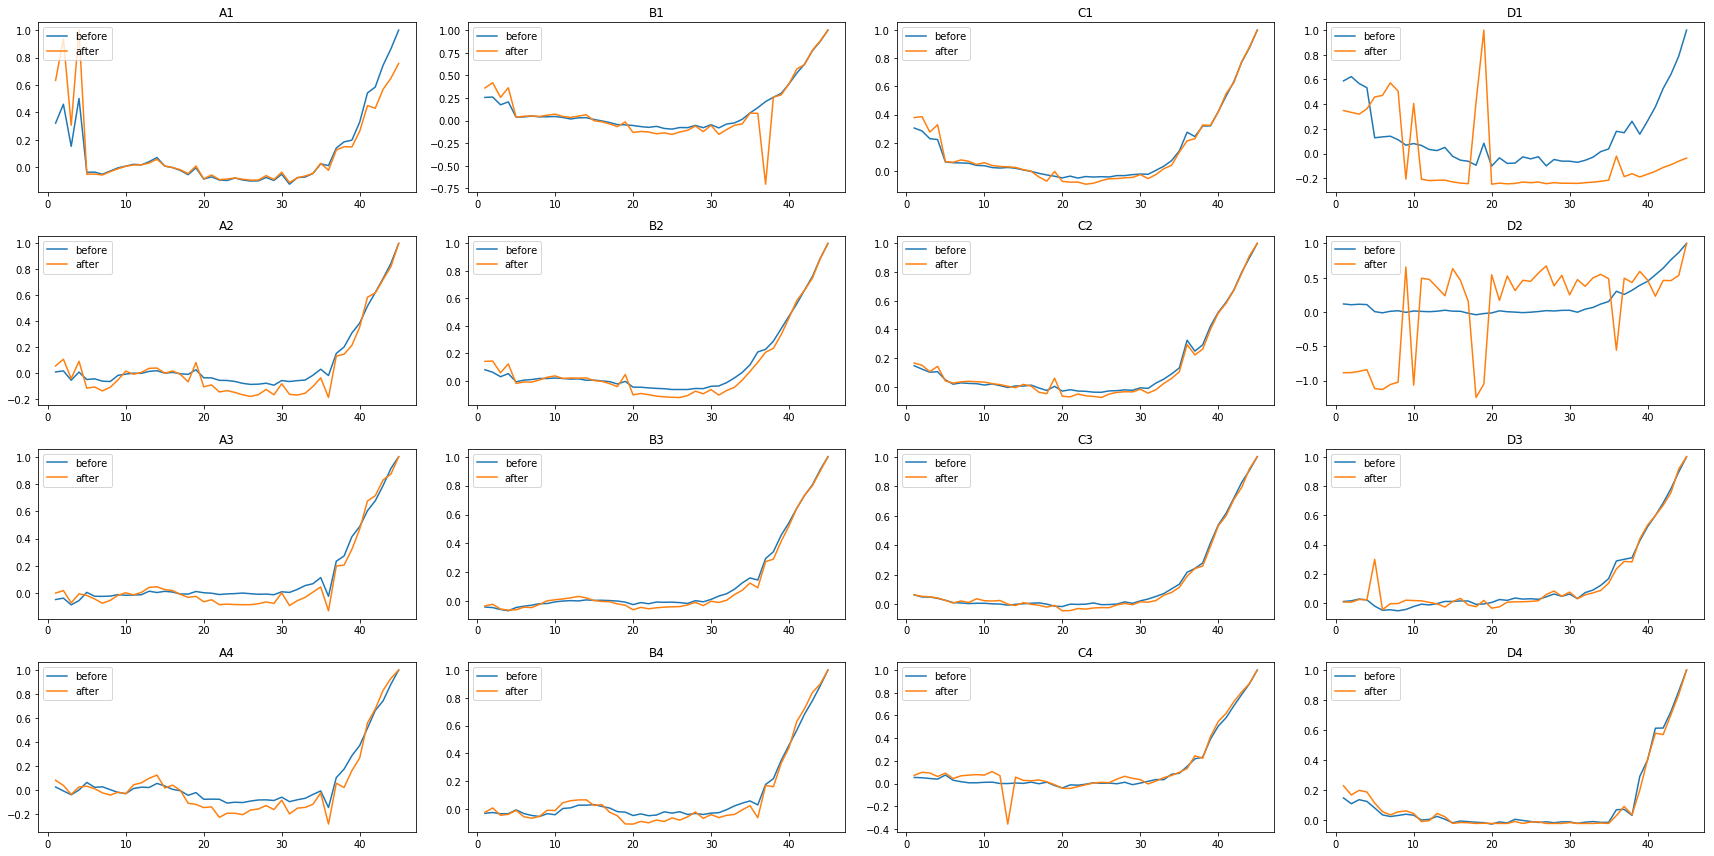

In [28]:
for temp in result_dict['rfu_sum'].keys():
    for ch, _dict in result_dict['rfu_sum'][temp].items():
        df = pd.DataFrame(_dict)
        df.index = range(1, 46)
        df = df.reindex(sorted(df.columns), axis=1)
        fig = df.plot(figsize=(12, 6), title=f'{temp} {ch}').get_figure()
        fig.savefig(f'{temp}_{ch}.png')
        
        key_before = map_dict[ch]+map_dict[temp[0]]
        df_before = dict_before[key_before]
        df_before.columns = col_li
        df_before.index = range(1, len(df_before)+1)
        
        df_before_norm = (df_before - df_before.loc[10:20].mean())/(df_before.max()-df_before.loc[10:20].mean())
        df_norm = (df-df.loc[10:20].mean())/(df.max()-df.loc[10:20].mean())
        
        fig, axes = plt.subplots(4, 4, figsize=(24, 12))
        n = 0
        for col in df_norm.columns:
            i = n%4
            j = n//4
            axes[i, j].plot(df_before_norm[col], label='before')
            axes[i, j].plot(df_norm[col], label='after')
            axes[i, j].set_title(col)
            n += 1
            axes[i, j].legend(loc='upper left')
        plt.tight_layout()
        plt.savefig(f'camera2_compare_{temp}_{ch}.png')

# investigate High Q670

In [29]:
import matplotlib.patches as _patches

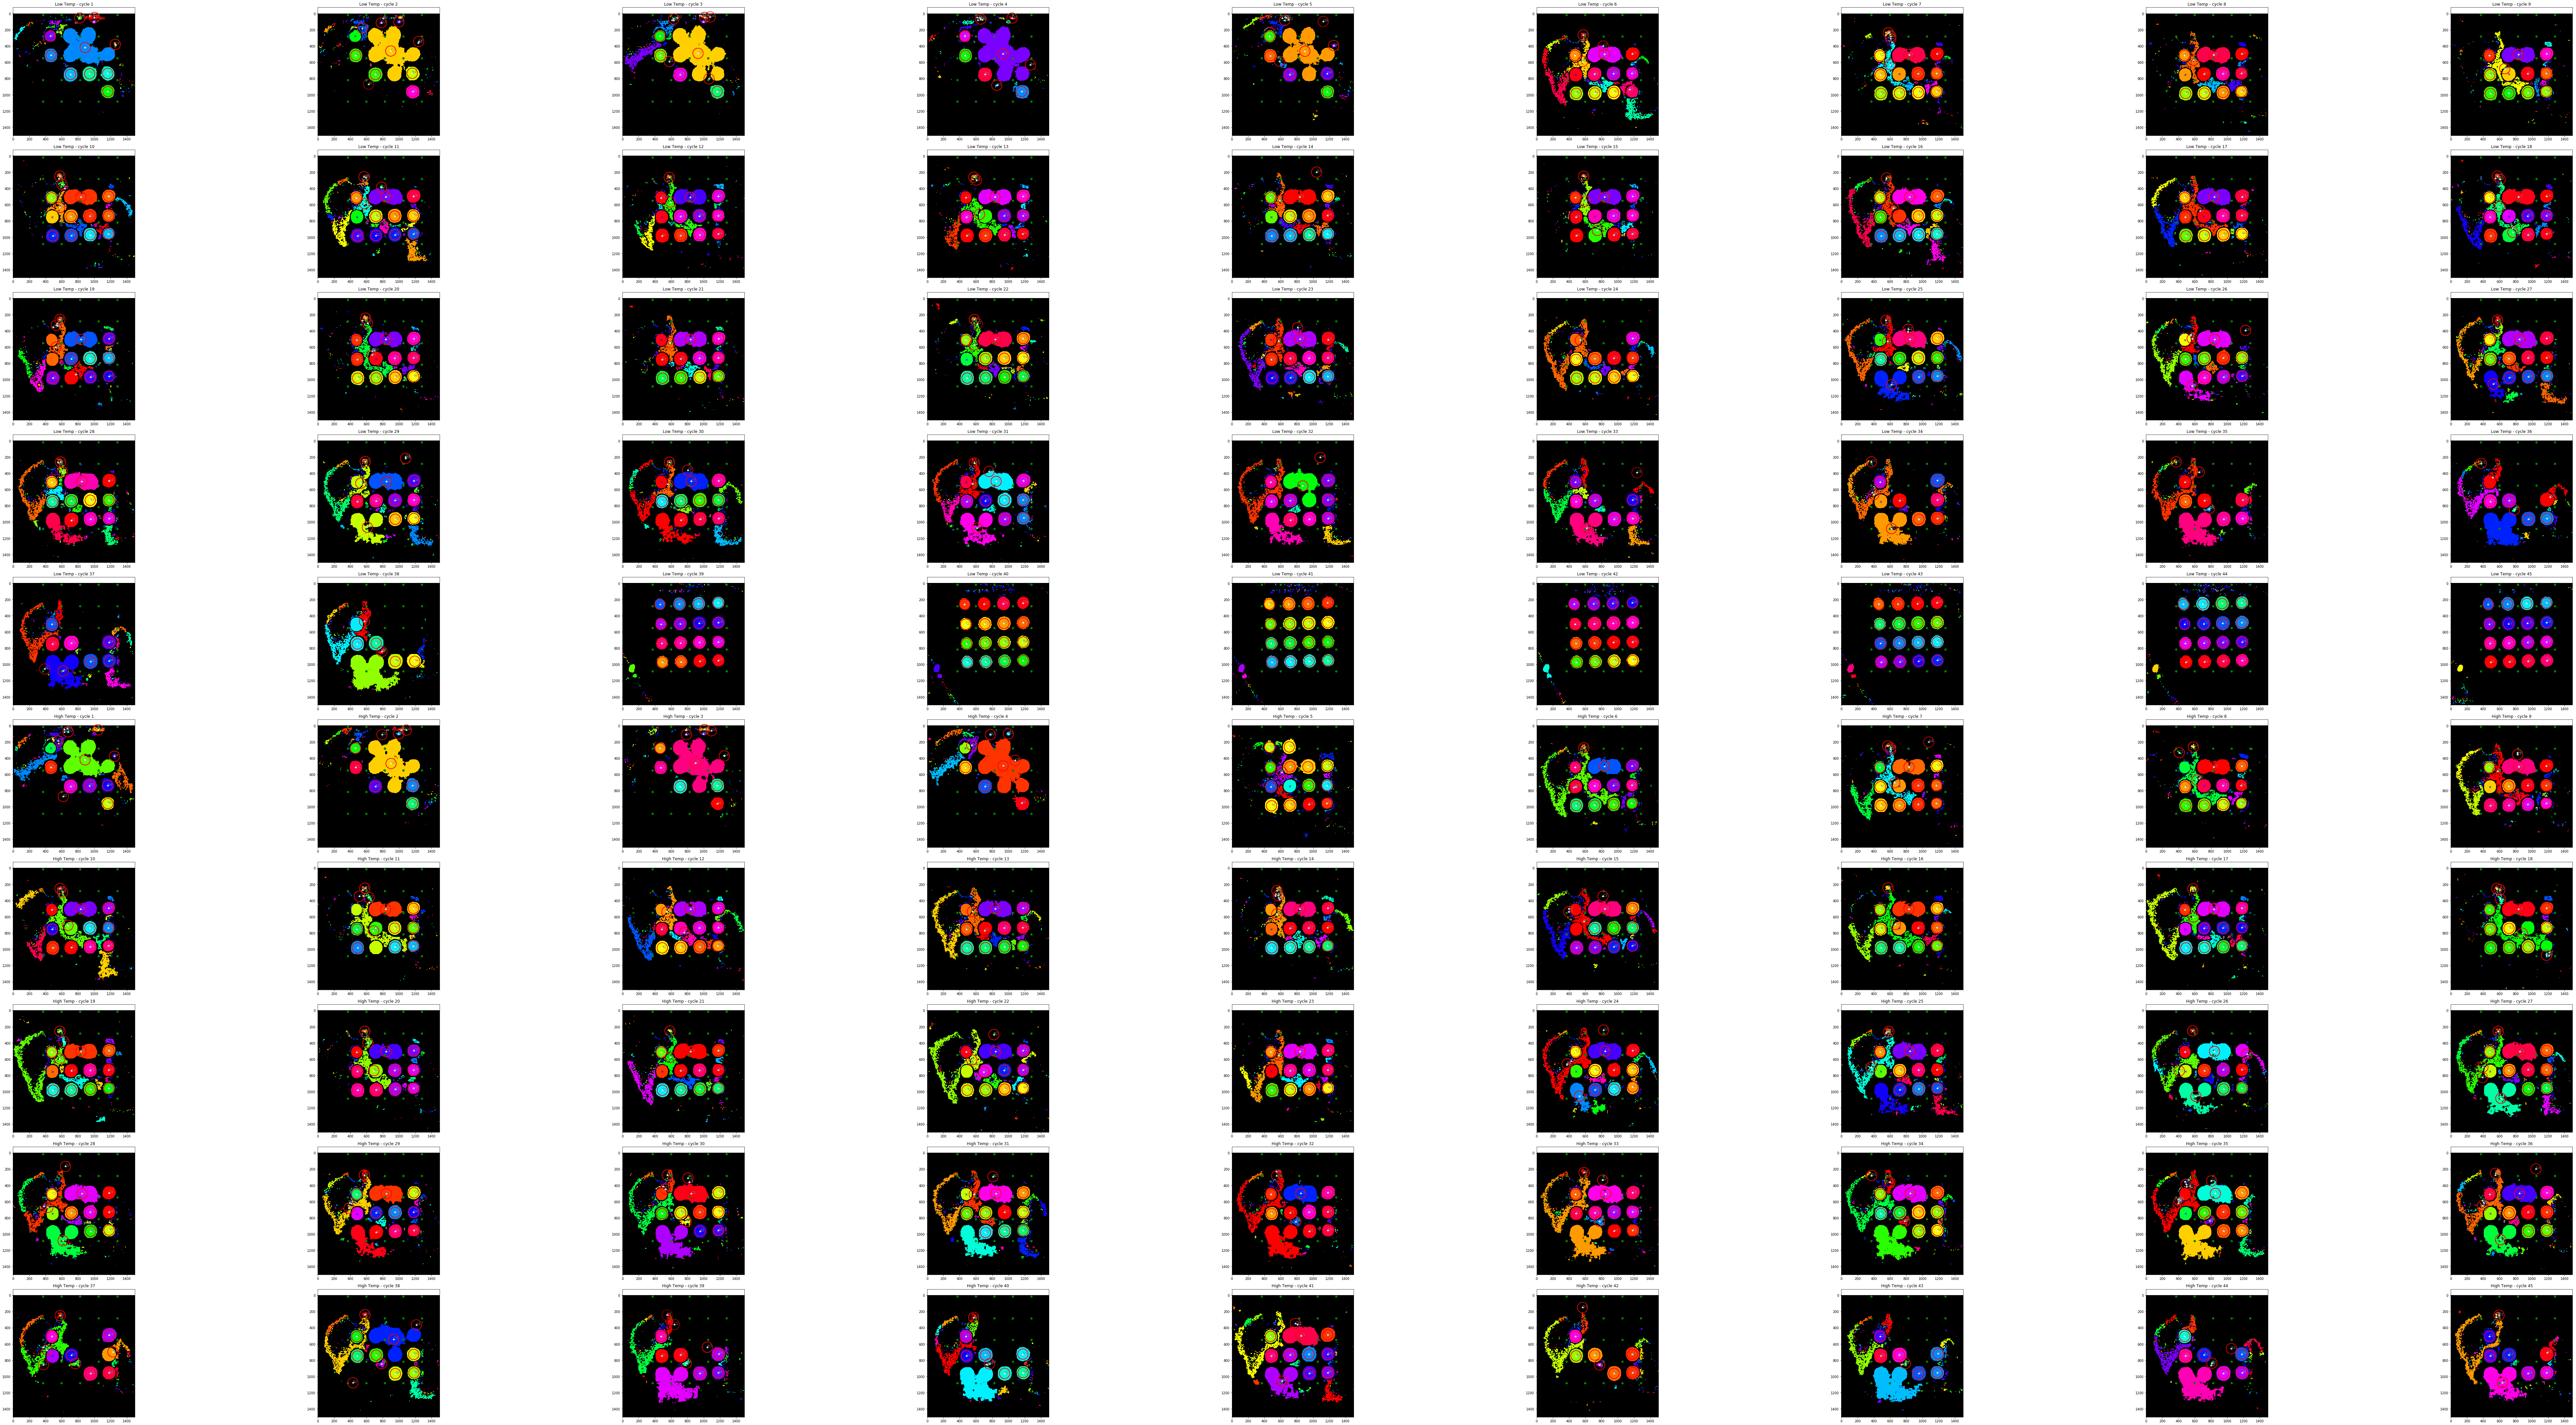

In [30]:
fig, ax = plt.subplots(10, 9, figsize=(24*5, 12*5))            
region_intensity_dict = {}
for t in range(2):
    region_intensity_dict[temp_li[t]] = {}
    for well in well_location_dict.keys():
        region_intensity_dict[temp_li[t]][well] = [0]*45
        
    for c in range(45):
        im_labeled = im_dict['Q670'][temp_li[t]][c]['labeled']
        image_label_overlay = skimage.color.label2rgb(im_labeled, bg_label=0, colors=colors_li)
        ax_x_coord = c//9+(t*5)
        ax_y_coord = c%9
        
        ax[ax_x_coord, ax_y_coord].imshow(image_label_overlay)
        ax[ax_x_coord, ax_y_coord].set_title(f'{temp_li[t]} - cycle {c+1}')
        ax[ax_x_coord, ax_y_coord].scatter(pts_x, pts_y, c='g')
        
        sorted_region_key = list(im_dict['Q670'][temp_li[t]][c]['regions'].keys())
        sorted_region_key.sort(reverse=True)
                
        center_at_cycle = {}
        circle_li = []
        for key in sorted_region_key:
            region_obj = im_dict['Q670'][temp_li[t]][c]['regions'][key]
            y, x = region_obj.centroid
            grid = get_grid_loc(x, y, result_dict['well_grid'][temp][ch])
            if grid is None:
                continue
            
            if grid not in center_at_cycle.keys():
                center = [x, y]
                center_at_cycle[grid] = center

                y_min, x_min, y_max, x_max = well_location_dict[grid]
                grid_center_x = (x_max-x_min)/2 + x_min
                rad = grid_center_x - x_min - 50
                circle_li.append(_patches.Circle(center, radius=rad, color='r', fill=False, linewidth=1))
            else:
                center = center_at_cycle[grid]
            well = get_well_loc(x, y, center, result_dict['well_grid'][temp][ch])

            if well is not None:
                val = region_intensity_dict[temp_li[t]][well][c]
                val += region_obj.intensity_image.sum()
                region_intensity_dict[temp_li[t]][well][c] = val

                ax[ax_x_coord, ax_y_coord].plot(x, y, color='white', marker='*')
                ax[ax_x_coord, ax_y_coord].text(x, y, well, color='gray')
            else:
                ax[ax_x_coord, ax_y_coord].plot(x, y, color='b', marker='x')
            for circle in circle_li:
                ax[ax_x_coord, ax_y_coord].add_artist(circle)

plt.tight_layout()
plt.savefig('camera1_q670_circle.png')
plt.show()